## <ins style = "color : orange">Report by KHOUTAIBI Iliass and BARAKA Rayane: </ins>

In this practical work, We will implement the PSOLA method for the analysis/synthesis of speech signals. We will then apply these implementations of the classic: <strong> A E I O U </strong> sound.

Before starting our report, we will start by importing some useful modules and implementing some helper functions.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf
import scipy as sp

### <ins style = " color : green"> Some helper functions: </ins>

We define a $\texttt{plot\_sound}$ function, which plots a given sound signal.

We also define a $\texttt{nextpow2}$ function, which computes the next power of two greater than or equal to a given float $ x $, in order to avoid overflow.

Finally, we define a $\texttt{period}$ function which, given a signal $ x $ and a sampling rate $ F_s $, returns:


\begin{aligned}
    P_a & : \text{the pitch of the signal} \\
    \text{voiced} & : \text{a boolean indicating whether the signal is voiced or not}
\end{aligned}



In [2]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in the same directory as the notebook.

In [476]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [477]:
x, Fs= sf.read(file_path)

In [478]:
IPython.display.Audio(file_path)

In [479]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

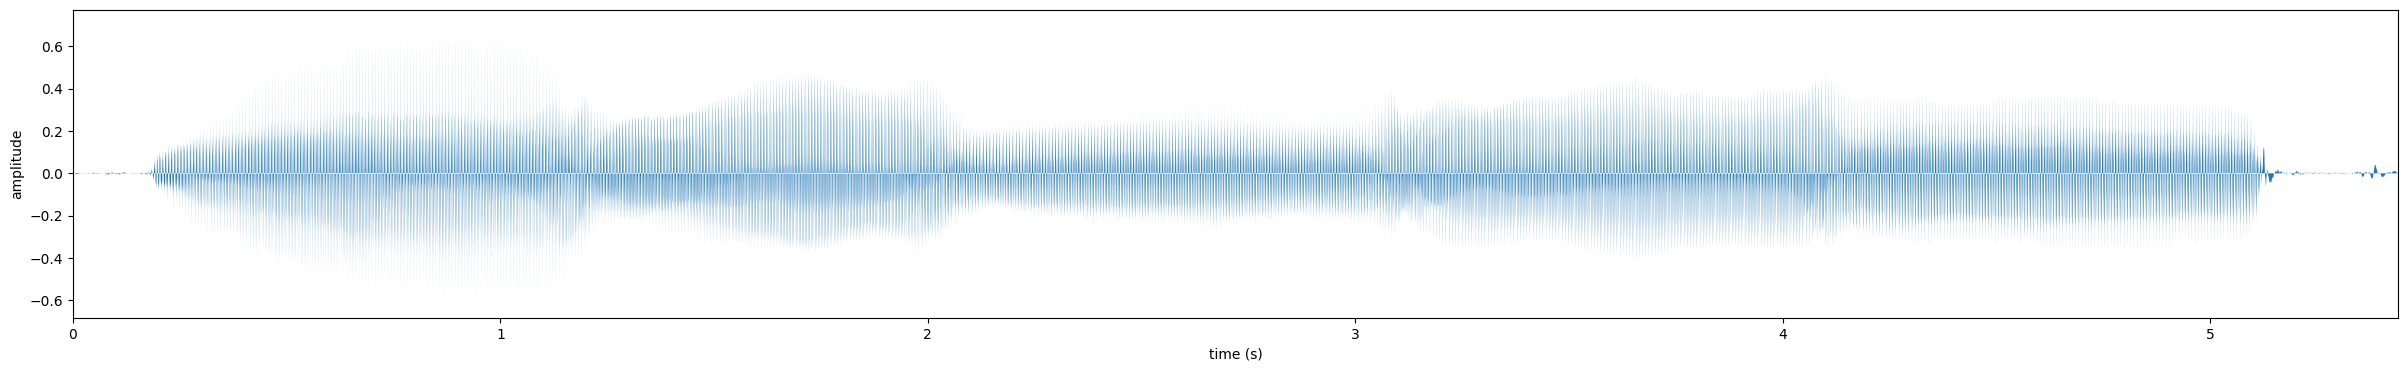

In [480]:
plot_sound(x, times)

In [481]:
sf.write('new_aeiou.wav',x, samplerate=Fs) # to write a new wave file

In [482]:
def AnalysisPitchMark(signal, Fs):
    
    n = len(signal)
    A = np.zeros((3, n))
    index = 1
    Pa = 0.1 * Fs
    ta = 0
    A[0, 0] = ta
    A[2, 0] = Pa
    

    while int(ta + 2.5 * Pa) <= n:
        
        ta = A[0, index - 1]
        Pa = A[2, index - 1]

        start = int(ta)
        end = int(ta + 2.5 * Pa)

        signal_segment = signal[start : end]

        Pa, voiced = period(signal_segment, Fs)
        A[1, index] = voiced
        A[2, index] = Pa
        ta = ta + Pa
        A[0, index] = ta

        index += 1

    return A[:, :index]

In [483]:
A = AnalysisPitchMark(x, Fs)
print(f"The A matrix is:\n {A}")

The A matrix is:
 [[0.0000e+00 7.8000e+01 1.8800e+02 ... 5.9471e+04 5.9581e+04 5.9691e+04]
 [0.0000e+00 1.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.1025e+03 7.8000e+01 1.1000e+02 ... 1.1000e+02 1.1000e+02 1.1000e+02]]


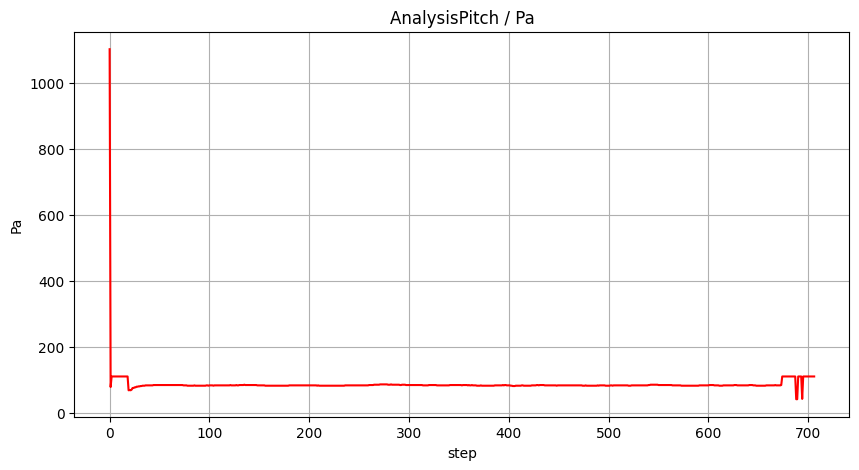

In [484]:
plt.figure(figsize=(10, 5))
plt.plot(A[2, :], color='red')
plt.grid()
plt.xlabel("step")
plt.ylabel("Pa")
plt.title("AnalysisPitch / Pa")
plt.show()

In [485]:
B = np.zeros((2, A.shape[1]))     
B[0, :] = A[0, :]
B[1, :] = np.arange(1, A.shape[1] + 1)

In [486]:
def Synthesis(s, Fs, A, B):
    
    nk_end = int(B[1, -1])
    y = np.zeros(int(B[0, -1] + A[2, nk_end - 1]))
    
    for k in range(B.shape[1]):

        n_k = int(B[1, k])

        if n_k >= A.shape[1]:  
            continue
        
        ts = B[0, k]
        ta = A[0, n_k] 
        Pa = A[2, n_k]
        
        start_ta = max(0, int(ta - Pa * 1/2))
        end_ta = min(len(s), int(ta + Pa * 1/2))
        
        start_ts = max(0, int(ts - Pa))
        end_ts = min(len(y), int(ts + Pa))
        
        x_inter = s[start_ta: end_ta]
        length_min = min(len(x_inter), end_ts - start_ts)

        x_inter = x_inter[: length_min]
        
        w = sp.signal.windows.hann(length_min)
        x_inter *= w

        
        y[start_ts: start_ts + length_min] += x_inter
    
    return y

In [487]:
y = Synthesis(x, Fs, A, B)
sf.write('synthesis.wav',y , samplerate=Fs)

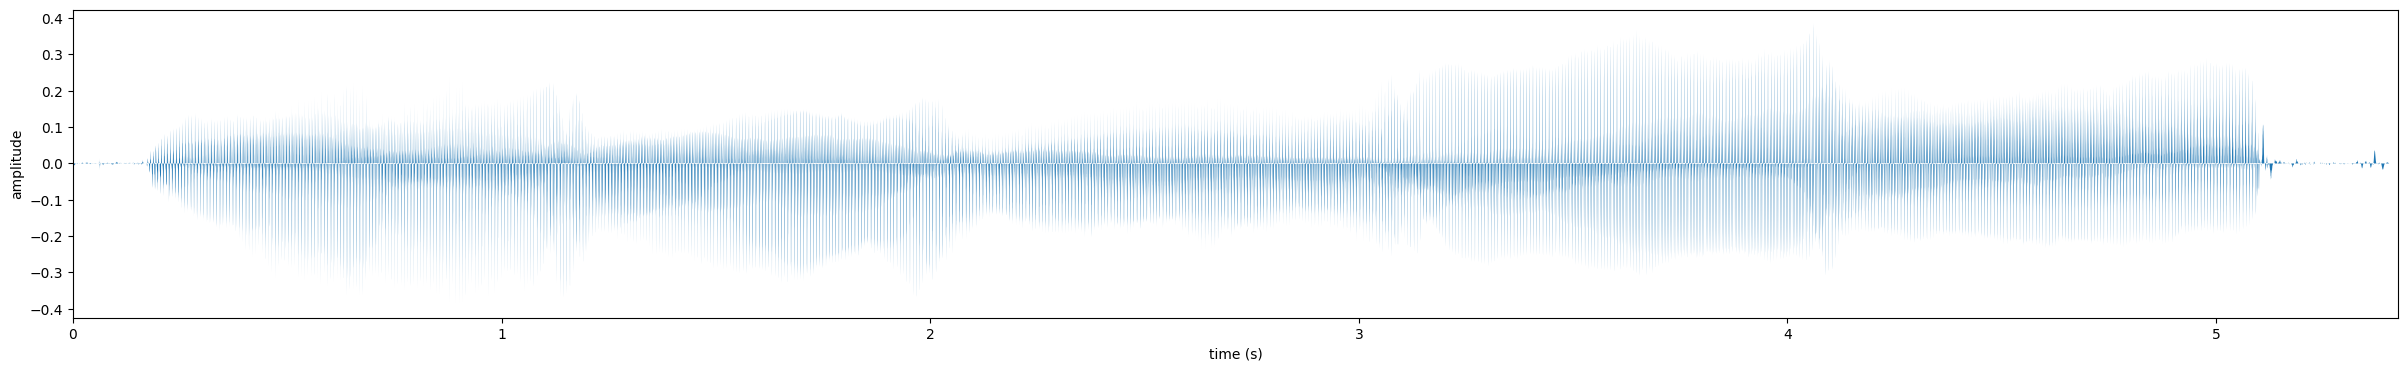

In [488]:
times =  np.arange(len(y))*timestep
plot_sound(y, times)

In [489]:
filename = 'synthesis.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

In [490]:
def ChangeTimeScale(alpha, A, Fs = Fs):
    
    n = 1
    B = [[0, 0]]
    ts = 0

    while int(n) < A.shape[1] - 1:

        ts = ts + A[2, int(round(n))]
        B.append([int(ts), int(n)])
        n += 1 / alpha

    B = np.array(B).T
    return B

In [491]:
B_2 = ChangeTimeScale(1/2, A, Fs)

In [492]:
y_2 = Synthesis(x, Fs, A, B_2)
sf.write('synthesis_2.wav',y_2 ,samplerate=Fs)

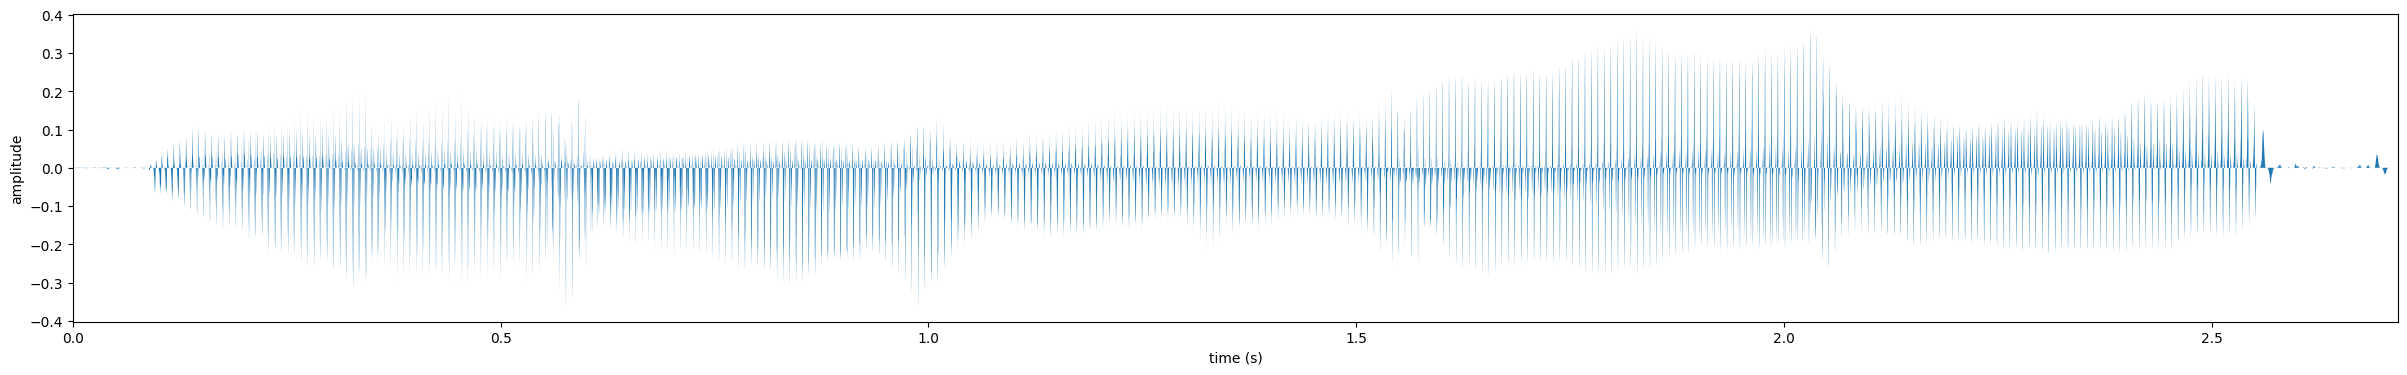

In [493]:
times =  np.arange(len(y_2))*timestep
plot_sound(y_2, times)

In [494]:
filename = 'synthesis_2.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

In [495]:
def ChangePitchScale(beta,A,Fs):
    
    B = [[0, 0]]
    n = 1
    ts = 0

    while int(n) < A.shape[1] - 1:

        scale = (1/beta) if A[1, int(n)] == 1 else 1
        ts = ts + scale * A[2, int(n)]
        B.append([int(ts), int(n)])
        n += scale

    B = np.array(B).T
    
    return B

In [496]:
B_3 = ChangePitchScale(5, A, Fs)

In [497]:
y_3 = Synthesis(x, Fs, A, B_3)
sf.write('synthesis_3.wav',y_3 , samplerate=Fs)

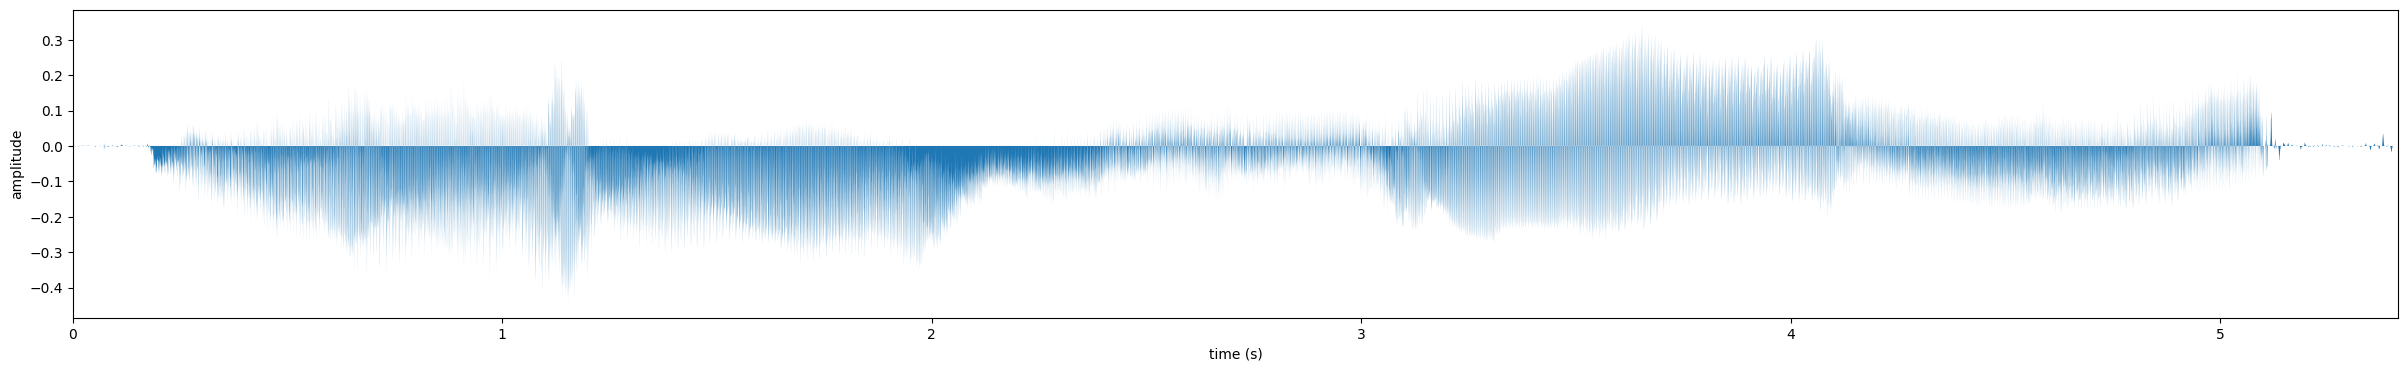

In [498]:
times =  np.arange(len(y_3))*timestep
plot_sound(y_3, times)

In [499]:
filename = 'synthesis_3.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

In [500]:
def ChangeBothScales(alpha, beta, A, Fs):
    
    B = [[0, 0]]  
    ts = 0      
    n = 0      

    while n < A.shape[1] - 1:  
        
        scale = (1 / beta) if A[1, int(n)] == 1 else 1
        ts += scale * A[2, int(n)]
        
        B.append([int(ts), int(n)])
        
        n += scale / alpha

    return np.array(B).T

In [501]:
B_final = ChangeBothScales(1/2, 1/2, A, Fs)

In [502]:
y_4 = Synthesis(x, Fs, A, B_final)
sf.write('synthesis_4.wav',y_4 , samplerate=Fs)

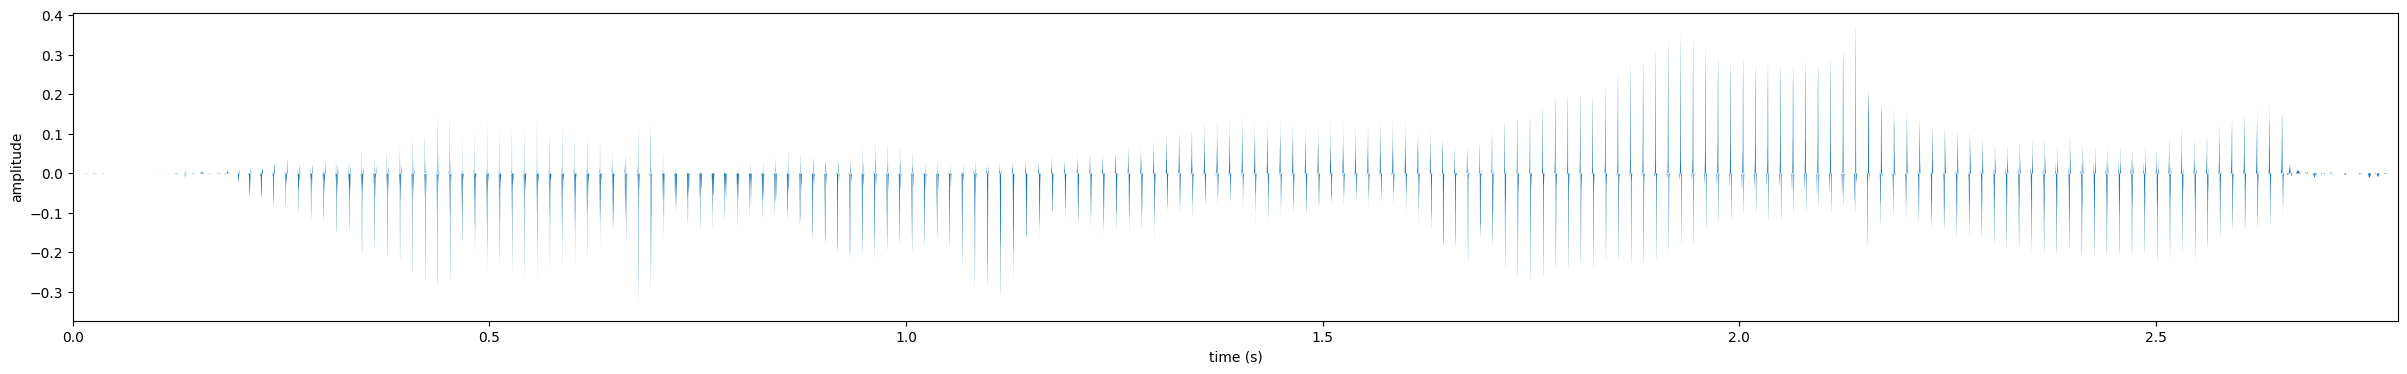

In [503]:
times =  np.arange(len(y_4))*timestep
plot_sound(y_4, times)

In [504]:
filename = 'synthesis_4.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 